## Is Bernie driving higher election turnout?

As a glum Warren supporter, I don't know who to vote for. Key to the pro-Bernie argument is the idea that he will inspire a surge of voters. If that is true, I would expect to see signatures of that at the primary level as well: overall primary turnout should be relatively high compared to previous years (because of all the inspired Bernie voters) and there should be a positive correlation between the degree of Bernie support and the increased turnout (see caveats toward the end of the notebook). I tried to see if the available turnout numbers support this idea.

I chose to plot **Democratic turnout**, defined as the number of ballots cast in the democratic primary/caucus of a state divided by the Voting Eligible Population, which as far as I understand includes voters of all parties. This makes sense to me because if Bernie is expanding the tent of the Democratic party then that's the relevant denominator.

I got voter turnout data from The US Elections Project http://www.electproject.org/home/voter-turnout/voter-turnout-data. In cases where there were multiple reported primaries (e.g. WA state's nonbinding straw poll and Nevada's nonbinding election) I chose the vote that actually led to delegates.

I got data for Bernie's share of the vote in each state from Wikipedia: https://en.wikipedia.org/wiki/Results_of_the_2020_Democratic_Party_presidential_primaries

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
import matplotlib as mpl
import re
import matplotlib.offsetbox as offsetbox

In [14]:
# H/T to StackOverflow user rtaft for this function
# https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.2g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])

In [15]:
turnout_data = pd.read_csv('./DemPrimaryTurnout.csv')
bernie_data = pd.read_csv('./BernieData.csv')

# Make a list of states that have already voted in 2020 (where I have a number for the ballots completely counted)
states_already_voted = turnout_data.loc[(turnout_data['Year']==2020) & (turnout_data['D_Ballots_Counted'].notnull()),
                                        'State']
# Make a list of states that Bernie has for-sure won (i.e. all ballots counted)
states_bernie_won = bernie_data.loc[(bernie_data['Year']==2020) & (bernie_data['Bernie_Won']),'State']
# Make State and Year into a multi-index for turnout_data to allow easy indexing by these variables
turnout_data.set_index(['State','Year'],inplace=True)
bernie_data.set_index(['State','Year'], inplace=True)
#Note, it's critical to sort the index to make sure the two dataframes match up!
turnout_data = turnout_data.sort_index()
bernie_data = bernie_data.sort_index()
print(states_already_voted)
print(states_bernie_won)

102           Alabama
105          Arkansas
117              Iowa
125         Minnesota
130            Nevada
131     New Hampshire
135    North Carolina
138          Oklahoma
142    South Carolina
144         Tennessee
145             Texas
146              Utah
147           Vermont
148          Virginia
Name: State, dtype: object
1     New Hampshire
2            Nevada
11          Vermont
13             Utah
Name: State, dtype: object


In [16]:
#Dem turnout is number of ballots cast in democratic primary divided by voting eligible population (x 100 for %ile)
turnout_data['dem_turnout'] = 100*(turnout_data['D_Ballots_Counted'] / turnout_data['VEP'])
turnout_data['relative_VEP'] = turnout_data['VEP'] / turnout_data.groupby(['Year']).VEP.max()

In [17]:
# Some plot formatting
font = {'family': 'Arial',
        'size': 16}
mpl.rc('font',**font)
bernie_cmap = plt.cm.Blues
bernie_cmap.set_bad(color='grey') #Not sure if this works, but hopefully set NaN to grey?
# Choose display range for Bernie's vote share. Some states (e.g. VT) are outside this range but it was really
# hard to see trends without restricting this range somewhat
cmap_norm = colors.Normalize(vmin=10,vmax=40)

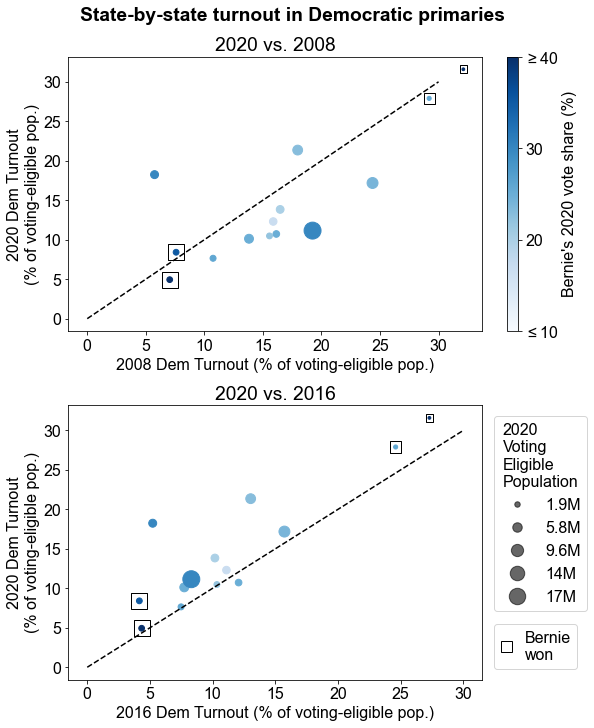

In [18]:
xaxis_year = [2008,2016]
yaxis_year = 2020

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(8,10),constrained_layout=True)

#Plot turnout. Scale dots by VEP in that state, color by Bernie's share of the vote
scatter = []
for p in range(2):
    # Plot voter turnout for one year vs the other. Size dots by voting eligible population, 
    # color by Bernie's vote share
    scatter.append(ax[p].scatter(turnout_data.loc[(states_already_voted, xaxis_year[p]), 'dem_turnout'],
                                 turnout_data.loc[(states_already_voted, yaxis_year),    'dem_turnout'],
                                 s = 400*turnout_data.loc[(states_already_voted, 2020),'relative_VEP'],
                                 c = 100*bernie_data.loc[(states_already_voted, 2020), 'Percent_Bernie'],
                                 cmap=bernie_cmap, norm=cmap_norm))
    # Put a box around states that Bernie has won
    boxes = ax[p].scatter(turnout_data.loc[(states_bernie_won, xaxis_year[p]), 'dem_turnout'],
                          turnout_data.loc[(states_bernie_won, yaxis_year), 'dem_turnout'],
                          s = 3000*turnout_data.loc[(states_bernie_won, 2020), 'relative_VEP'],
                          facecolors='none', edgecolor='k', linewidth=1, marker='s')
    ax[p].plot([0,30],[0,30],'k--')
    ax[p].set_xlabel('{} Dem Turnout (% of voting-eligible pop.)'.format(xaxis_year[p]))
    ax[p].set_ylabel('{} Dem Turnout\n(% of voting-eligible pop.)'.format(yaxis_year))
    ax[p].set_title('{} vs. {}'.format(yaxis_year, xaxis_year[p]))

# Legend for population size (VEP)
handles, labels = scatter[1].legend_elements(prop="sizes", alpha=0.6)
#Convert labels in arbitrary units back to population numbers
labels_as_int = np.array([int(re.findall(r'\d+', s)[0]) for s in labels])
true_label_as_number = (turnout_data.groupby(['Year']).VEP.max()[2020]/400)*labels_as_int
true_labels = [human_format(n) for n in true_label_as_number]
legend2 = ax[1].legend(handles[::2], true_labels[::2],bbox_to_anchor=[1.01,.99], 
                       title="2020\nVoting\nEligible\nPopulation")
ax[1].add_artist(legend2)

# Legend for 'Bernie-won' boxes
sq2 = mpl.patches.Rectangle((0,0),1,10,fill=None,edgecolor='k',label='Bernie\nwon')
ax[1].legend(loc=3,handles=[sq2],handlelength=.7,bbox_to_anchor=[1.01,.01])

# Colorbar for showing Bernie's vote share
x = mpl.cm.ScalarMappable(norm=cmap_norm, cmap=bernie_cmap)
x.set_array([])
cbar = fig.colorbar(x,ax=ax[0])
cbar.set_label('Bernie\'s 2020 vote share (%)')
cbar.set_ticks([10,20,30,40])
cbar.set_ticklabels(['$\\mathdefault{\leq10}$','20','30','$\\mathdefault{\geq40}$'])

suptitle_font = {'weight': 'bold'}
fig.suptitle('State-by-state turnout in Democratic primaries',fontweight='bold')
plt.show()

I have two takeaways:
  1. I have been hearing a lot of talk about turnout not being amazing in the primaries. While turnout generally has not reached 2008 levels of enthusiasm, it is encouraging that a larger fraction of the electorate is voting than in 2016! 
  2. The correlation between strong Bernie support and voter turnout is not strong. There are some states that are doing well there but they need to be a bit stronger
  
As a control for big changes in the denominator (the voting eligible population), I plotted the VEP for 2008 and 2016 against 2020. It seems like overall the correlation is pretty tight; the bigger states in the mix seem to have grown a lot, e.g. Texas I think?

Text(0.5, 0, '2016 Voting eligible pop. (millions)')

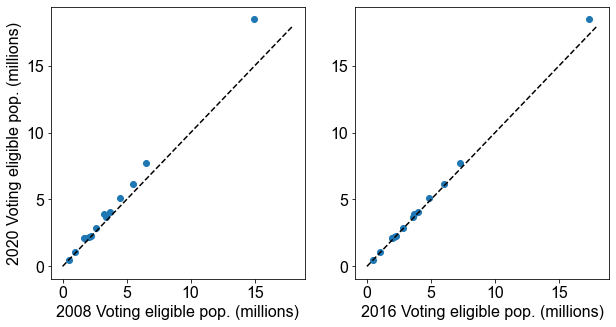

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax[0].scatter(turnout_data.loc[(states_already_voted, 2008), 'VEP']/1e6,
              turnout_data.loc[(states_already_voted, 2020), 'VEP']/1e6)
ax[0].plot([0,18],[0,18],'k--')
ax[0].set_xlabel('2008 Voting eligible pop. (millions)')
ax[0].set_ylabel('2020 Voting eligible pop. (millions)')
ax[1].scatter(turnout_data.loc[(states_already_voted, 2016), 'VEP']/1e6,
              turnout_data.loc[(states_already_voted, 2020), 'VEP']/1e6)
ax[1].plot([0,18],[0,18],'k--')
ax[1].set_xlabel('2016 Voting eligible pop. (millions)')

The biggest outlier is Minnesota, which is because they switched from primary to caucus. Virginia also had a big bump in voting, though that state was noteable for going towards Biden.

In [20]:
#Display democratic turnout percentage for each states so far in the primary and each race.
turnout_data.loc[(states_already_voted,slice(None)),'dem_turnout'].unstack(level=1)

Year,2008,2016,2020
State,,,
Alabama,15.880878,11.101108,12.306401
Arkansas,15.561063,10.341980,10.479806
Iowa,10.743270,7.484438,7.647999
Minnesota,5.748096,5.220716,18.242613
Nevada,7.042257,4.338682,4.939111
New Hampshire,29.196891,24.598594,27.900371
North Carolina,24.362835,15.728056,17.183461
Oklahoma,16.145219,12.072689,10.726375
South Carolina,16.474432,10.183009,13.834791


What about comparing the 2008 primary and the 2016 primary? At least there we have information from all the states. Again this doesn't seem to paint a super clear picture of a voter surge in states that Bernie did really well in.

The major outlier here is Michigan (the bigger gray dot above the line; the other dot above the line is New Mexico). I think this is probably the clearest the idea of a Bernie surge gets? And the interpretation is that this state would have gone to Clinton but the Bernie surge made it competitive in addition to dramatically increasing the vote tally there. There are also a bunch of very low-dem turnout states where Bernie actually did quite well, but in the electoral college system I am doubtful that that counts for much.

Overall I don't buy a nationwide trend of a game-changing Bernie surge with a clear indicator of it in just one state

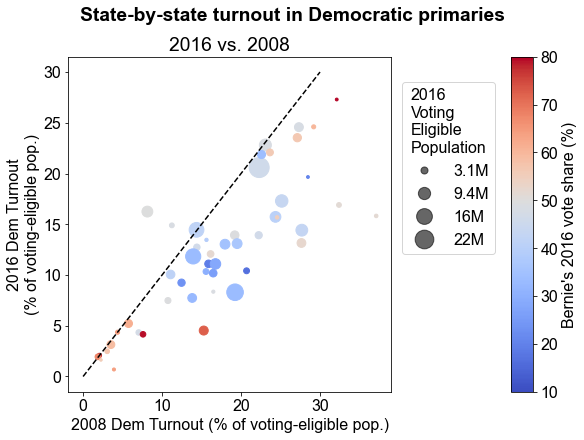

In [21]:
xaxis_year = 2008
yaxis_year = 2016
cmap_norm = colors.TwoSlopeNorm(vmin=10,vcenter=50,vmax=80)
fig,ax = plt.subplots(figsize=(8,6),constrained_layout=True)

#Plot turnout. Scale dots by VEP in that state, color by Bernie's share of the vote
scatter = ax.scatter(turnout_data.loc[(slice(None), xaxis_year), 'dem_turnout'],
                     turnout_data.loc[(slice(None), yaxis_year),    'dem_turnout'],
                     s = 400*turnout_data.loc[(slice(None), 2016),'relative_VEP'],
                     c = 100*bernie_data.loc[(slice(None), 2016), 'Percent_Bernie'],
                     cmap='coolwarm', norm=cmap_norm)
ax.plot([0,30],[0,30],'k--')
ax.set_xlabel('{} Dem Turnout (% of voting-eligible pop.)'.format(xaxis_year))
ax.set_ylabel('{} Dem Turnout\n(% of voting-eligible pop.)'.format(yaxis_year))
ax.set_title('{} vs. {}'.format(yaxis_year, xaxis_year))

#Legend for population size (VEP)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
#Convert labels in arbitrary units back to population numbers
labels_as_int = np.array([int(re.findall(r'\d+', s)[0]) for s in labels])
true_label_as_number = (turnout_data.groupby(['Year']).VEP.max()[2016]/400)*labels_as_int
true_labels = [human_format(n) for n in true_label_as_number]
legend2 = ax.legend(handles[::2], true_labels[::2],bbox_to_anchor=[1.01,.95], 
                       title="2016\nVoting\nEligible\nPopulation")

#Colorbar for showing Bernie's vote share
x = mpl.cm.ScalarMappable(norm=cmap_norm, cmap='coolwarm')
x.set_array([])
cbar = fig.colorbar(x, ax=ax)
cbar.set_label('Bernie\'s 2016 vote share (%)')
#cbar.set_ticks([10,20,30,40])
#cbar.set_ticklabels(['$\\mathdefault{\leq10}$','20','30','$\\mathdefault{\geq40}$'])

suptitle_font = {'weight': 'bold'}
fig.suptitle('State-by-state turnout in Democratic primaries',fontweight='bold')
plt.show()

Try plotting Bernie support vs. turnout directly for 2016: subtract the percent turnout in 2008 from the percent turnout in 2016, and then plot Bernie's share of the vote against that. I would expect that if Bernie was drawing supporters out then there should be a positive correlation between Bernie's voter share and voter turnout in that state. Alternative possibilities
  1. That state already has high turnout and is generally favorable to Bernie (e.g. VT). The argument for Bernie as a turnout-candidate is not helped a lot by these states: there is no _increase_ in voter turnout because of Bernie.
  2. Bernie does not win the election in a state (or come close), but he puts up a surprisingly good fight by drawing voters in. In this situation turnout is high but Bernie's share is not. If that's the case you might expect that turnout would be high relative to another election, e.g. 2008. This happens in two states: Michigan and New Mexico. It is an interesting signal for Bernie's candidacy that he drove up turnout in a purple-ish state like MI, but it doesn't seem to have replicated in any other states with similar profiles and importance in the electoral college.
  3. It is also possible that Bernie does inspire higher turnout from his supporters, but also from never-Bernie voters, so voter turnout also increases as vote share for Bernie decreases. If this is the case the two effects could wash each other out and show little correlation between Bernie vote share and turnout. This would not be a great argument in support of Bernie: if he is already polarizing on the left and his base is not large enough to dominate in the primaries it is unclear how he will do in the general.

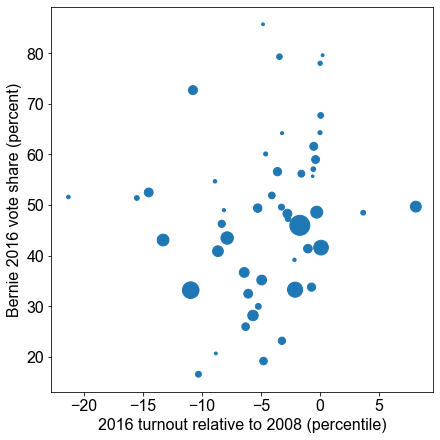

In [22]:
turnout_difference = turnout_data.loc[(slice(None),2016),'dem_turnout'].to_numpy() - turnout_data.loc[(slice(None),2008),'dem_turnout'].to_numpy()
fig, ax = plt.subplots(figsize=(6,6),constrained_layout=True)
scatter = ax.scatter(turnout_difference,
                     100*bernie_data.loc[(slice(None),2016),'Percent_Bernie'],
                     s=400*turnout_data.loc[(slice(None), 2016),'relative_VEP'])
ax.set_xlabel('2016 turnout relative to 2008 (percentile)')
ax.set_ylabel('Bernie 2016 vote share (percent)')
plt.show()